In [1]:
# import basic libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')
import json
import unidecode
import spacy
nlp = spacy.load("es_core_news_md")
import unidecode

In [2]:
# Getting "anti-taxonomy"
anti_taxonomy_file_name = "anti_taxonomy_export_2.json"
anti_taxonomy_file = open(anti_taxonomy_file_name, 'r')
anti_taxonomy = json.load(anti_taxonomy_file) 
anti_taxonomy += ['stroke', 'span', 'trebuchet', 'webkit', 'kerning', 'calibri', 'font', 'text', 'margin', 'm' , 'ten', 'www', 'https' 'https', 'none']

In [3]:
# function to clean text
def review_to_words(raw_review):
    # 1. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", raw_review) 

    # 2. Convert to lower case and only words
    only_words = letters_only.lower()
    only_words = " ".join(only_words.split())
    # 2.1 the nlp doc and words ❤️ 
    doc = nlp(only_words)
    lexical_tokens = [tok.lemma_ for tok in doc if tok.pos_ != 'PRON' and not (tok.is_punct | tok.is_stop)]
    words = [t.lower() for t in lexical_tokens if len(t) > 2 and t.isalpha()]
    # 3. Remove Stopwords. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("spanish"))  
    # 4. Remove stop words
    meaningful_words = [w for w in words if not w in stops]  #returns a list 
    # 4.1 if you want remove words in anti-taxonomy
    #meaningful_words = list(filter(is_in_anti_tax, meaningful_words)) 
    meaningful_words = [unidecode.unidecode(w) for w in meaningful_words if w.strip() not in anti_taxonomy]
    # 5. Stem words. Need to define porter stemmer above
    #meaningful_words = [(lambda x: stemmer.stem(x) if len(x) > 5 else x)(word) for word in meaningful_words]
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))  

In [4]:
file = open("sin_tildes_sexperto.json", 'r')
questions = json.load(file)

In [5]:
questions[0]

{'Name': '?Es necesario tomar anticoncepcion de emergencia cuando se utiliza el anillo anticonceptivo vaginal (NuvaRing) sin condon?',
 'respuestas_juntas': 'Solo cuando comienzas a usar el anillo anticonceptivo vaginal en un dia diferente a los primeros cinco dias de la menstruacion, es necesario utilizar un metodo anticonceptivo adicional. Si este es tu caso y no usaste condon si seria necesario usar anticoncepcion de emergencia. Te recomiendo asistir a una asesoria en anticoncepcion en tu centro de atencion en salud. Recuerda utilizar condon en todas las relaciones sexuales.'}

In [6]:
# apply it to our text data   
# dataset is named wine_data and the text are in the column "wmn"  
processed_wmn = [review_to_words("{} {}".format(question["Name"], question["respuestas_juntas"])) for question in questions] 
len(processed_wmn)

1137

In [7]:
" ".join(processed_wmn[0].split())

'tomar anticoncepcion emergencia anillar anticonceptivo vaginal nuvaring condon anillar anticonceptivo vaginal menstruacion anticonceptivo casar condon serio anticoncepcion emergencia recomer asistir asesoria anticoncepcion centrar atencion salud condon relacionar sexual'

In [8]:
# build a corpus for the word2vec model  
def build_corpus(data):
    corpus = []
    for sentence in data:
        sentence = " ".join(sentence.split())
        word_list = sentence.split(" ")  
        corpus.append(word_list)   
    return corpus

In [9]:
corpus = build_corpus(processed_wmn)
len(corpus)

1137

In [66]:
import pickle
with open('corpus_sexperto_with_lemma_with_s-08062020.pkl', 'wb') as corpus_export_file:
    pickle.dump(corpus, corpus_export_file)

# Taxonomy tree building 

In [10]:
## run if u wanna open corpus preloaded
import pickle
with open('corpus_sexperto_with_lemma_with_s-08062020.pkl', 'rb') as corpus_import_file:
    corpus = pickle.load(corpus_import_file)

# Thanks Sexperto ❤️🤓

In [11]:
import time;
from gensim.models import word2vec 

In [68]:
ts1 = time.time()
# run the model  
print()
model = word2vec.Word2Vec(corpus, size=2000, window=6, min_count=2000, workers=16)
print(len(model.wv.vocab))
print(time.time() - ts1)


1
0.10759997367858887


In [12]:
# A ver iterando sobre 

def getModelByIteratingMin_count(words):
    modelBIMC = None
    min_count = 1
    while min_count < 2000:
        min_count += 1
        try: 
            modelBIMC = word2vec.Word2Vec(corpus, size=2000, window=6, min_count=min_count, workers=16)
            should_continue = True
            for word in words:
                if word not in modelBIMC.wv.vocab:
                    should_continue = False
                    print("this word is not in model", word)
                    break
            if not should_continue:
                min_count -= 1 
                modelBIMC = word2vec.Word2Vec(corpus, size=2000, window=6, min_count=min_count, workers=16)
                break
        except:
            continue
    return modelBIMC, min_count

In [13]:
min_words = ["abortar", "hormonal", "condon", "preservativo", "embarazo", "pastilla", "anticonceptivo", "hormona", "diu", "menstruacion", "anticoncepcion"]
best_model, min_count = getModelByIteratingMin_count(min_words)

this word is not in model preservativo


In [72]:
min_count

71

In [73]:
best_model.wv.most_similar('preservativo', topn=50)

[('barrera', 0.9999427795410156),
 ('unico', 0.9999266862869263),
 ('espermatozoide', 0.9999240040779114),
 ('embarazo', 0.9998973608016968),
 ('dispositivo', 0.9998928308486938),
 ('prevenir', 0.9998753070831299),
 ('hormona', 0.9998744130134583),
 ('haber', 0.9998742341995239),
 ('requerir', 0.9998567700386047),
 ('disminuir', 0.9998560547828674),
 ('condon', 0.999855637550354),
 ('enfermedad', 0.9998552799224854),
 ('diu', 0.9998523592948914),
 ('recomendar', 0.9998512864112854),
 ('proteger', 0.999847412109375),
 ('dudar', 0.9998391270637512),
 ('probar', 0.9998373985290527),
 ('sangrar', 0.9998363256454468),
 ('sintomas', 0.9998239874839783),
 ('iniciar', 0.999822735786438),
 ('ano', 0.9998220205307007),
 ('especificar', 0.9998176693916321),
 ('medicamento', 0.9998155832290649),
 ('adecuar', 0.9998092651367188),
 ('causar', 0.9998089671134949),
 ('medicar', 0.9998044371604919),
 ('algun', 0.9998043775558472),
 ('posibilidad', 0.9998034238815308),
 ('oral', 0.9997937679290771),
 ('

In [77]:
[(item[0], round(item[1],5)) for item in best_model.wv.most_similar('infección', topn=50)]

KeyError: "word 'infección' not in vocabulary"

In [78]:
[x for x in best_model.wv.vocab]

['tomar',
 'anticoncepcion',
 'emergencia',
 'anticonceptivo',
 'vaginal',
 'condon',
 'menstruacion',
 'casar',
 'recomer',
 'asistir',
 'asesoria',
 'centrar',
 'atencion',
 'salud',
 'relacionar',
 'sexual',
 'parejo',
 'embarazar',
 'vagina',
 'penetracion',
 'eyaculacion',
 'semen',
 'presentar',
 'siguiente',
 'relacion',
 'efectividad',
 'prevenir',
 'embarazo',
 'infeccion',
 'transmision',
 'informacion',
 'invitar',
 'consultar',
 'sexperto',
 'pastilla',
 'medicar',
 'garantizar',
 'entidad',
 'requerir',
 'pagina',
 'segundo',
 'espermatozoide',
 'efecto',
 'personar',
 'citar',
 'iniciar',
 'poder',
 'ano',
 'oral',
 'periodo',
 'menstrual',
 'disminuir',
 'dudar',
 'probar',
 'barrera',
 'preservativo',
 'implantar',
 'metodos',
 'colombia',
 'dispositivo',
 'hormonal',
 'hormona',
 'algun',
 'temer',
 'encontrar',
 'medicamento',
 'orinar',
 'querer',
 'seguro',
 'solicitar',
 'sangrar',
 'necesidad',
 'genital',
 'femenino',
 'posibilidad',
 'contactar',
 'adecuar',
 'a

/Users/davidbautista/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


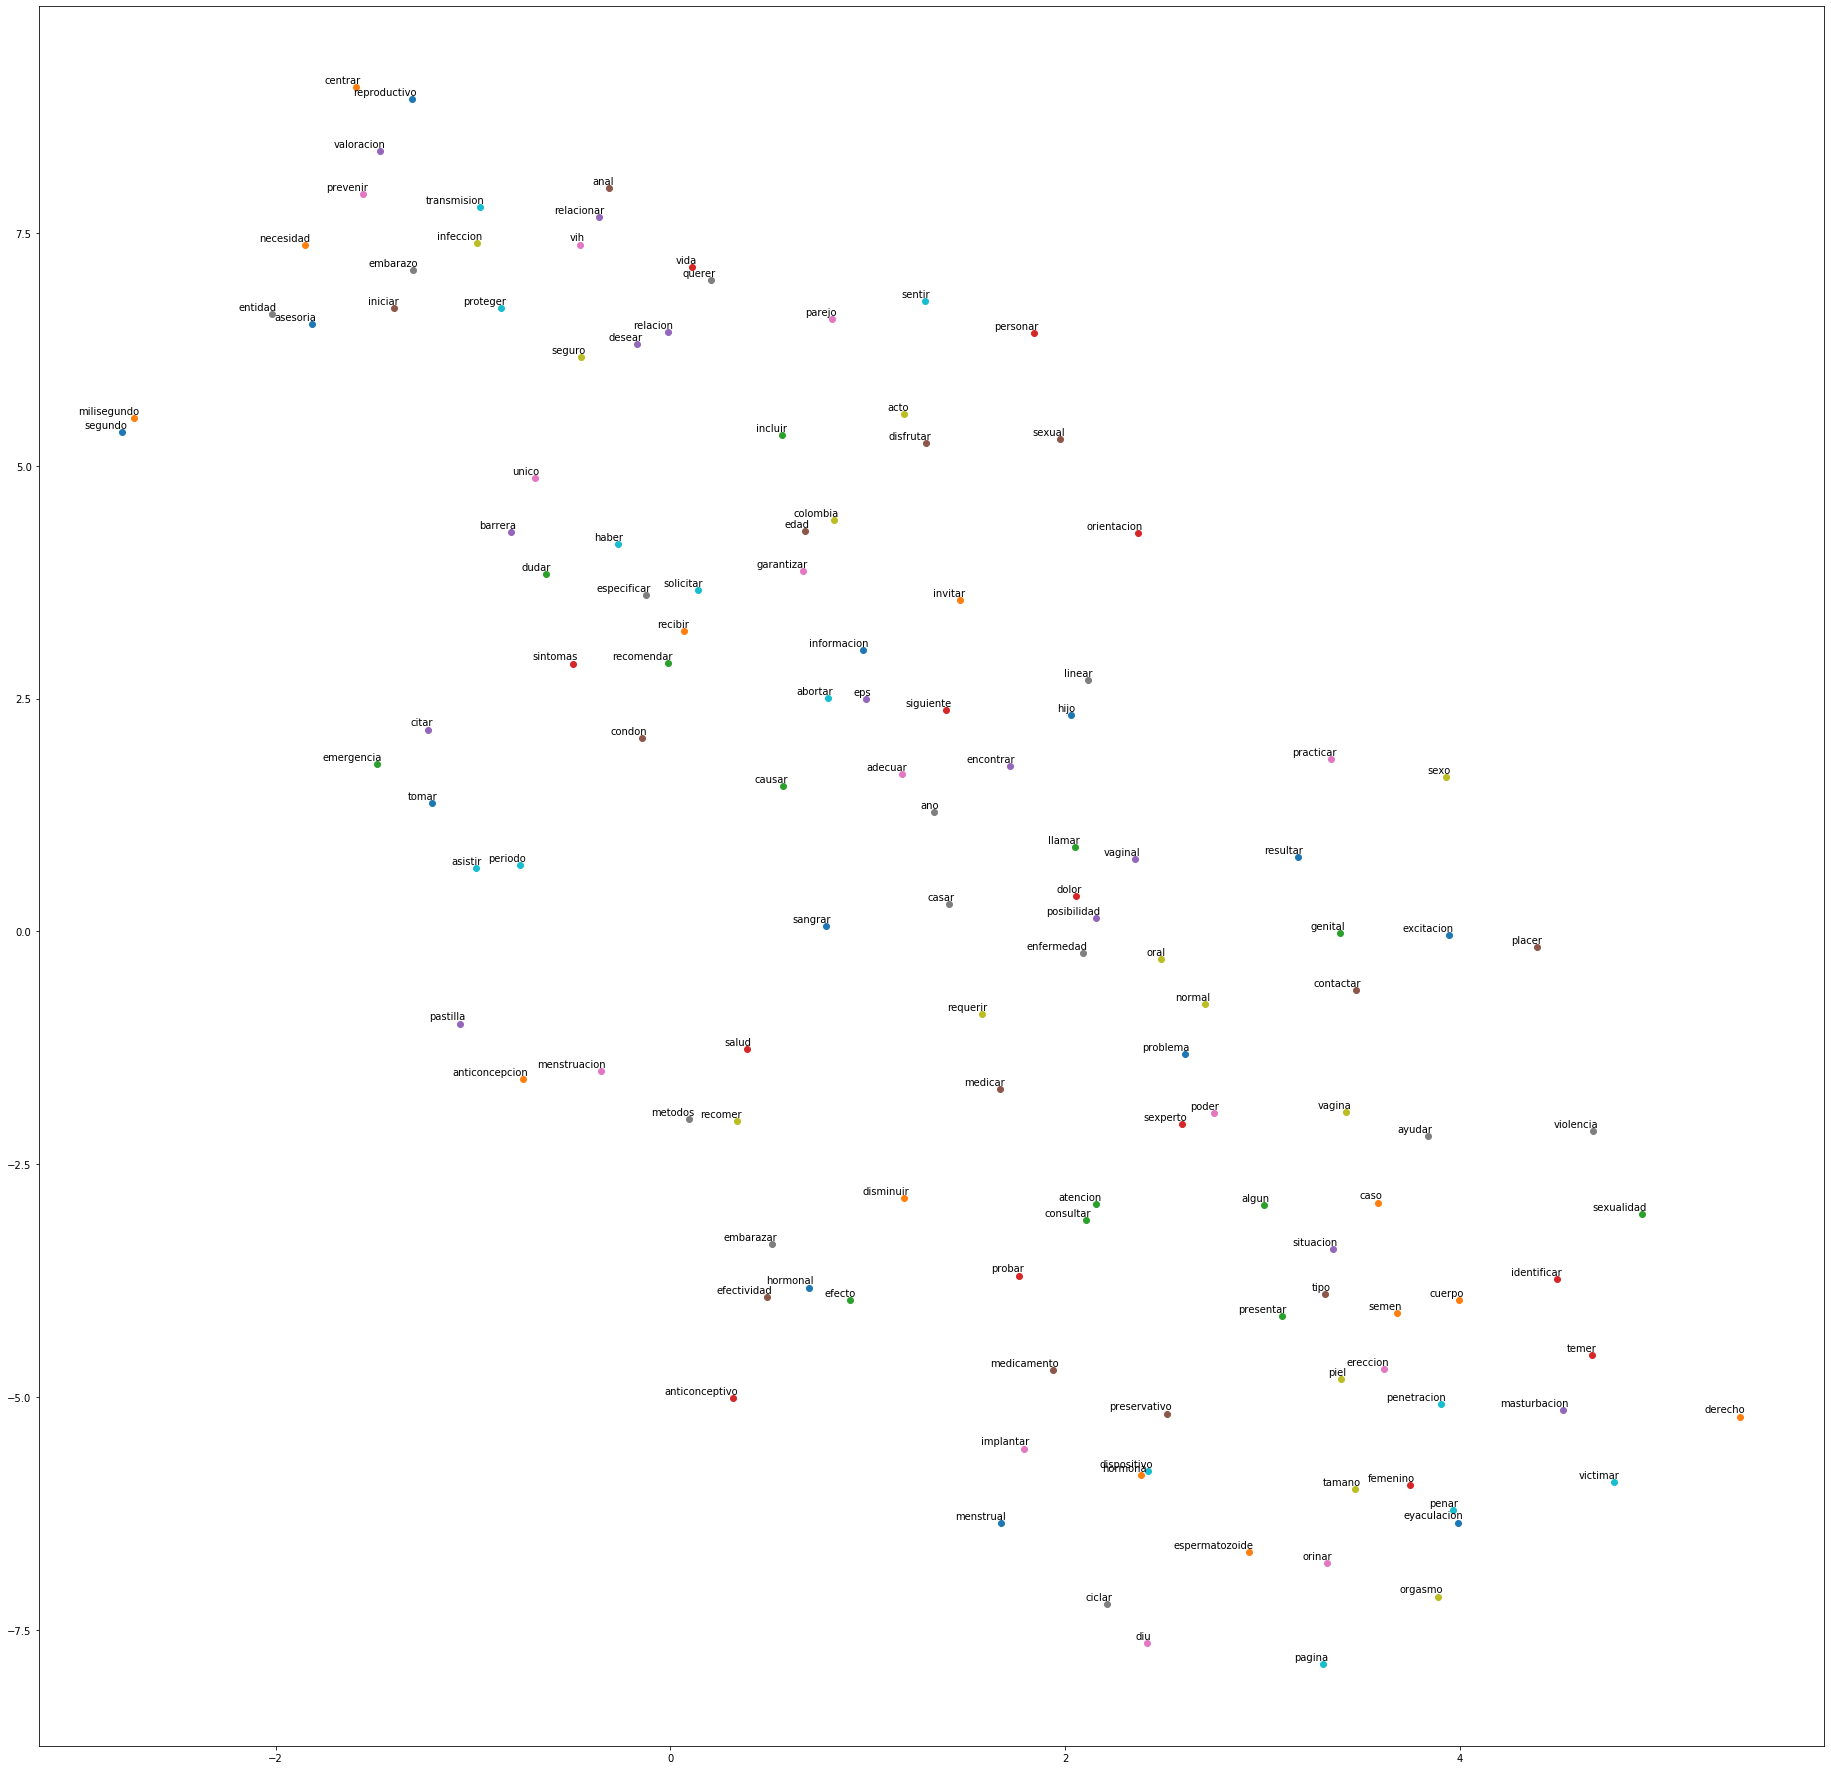

In [79]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
# define the function to compute the dimensionality reduction
# and then produce the biplot

"Creates a TSNE model and plots it"
labels = []
tokens = []

for word in best_model.wv.vocab:
    tokens.append(best_model[word])
    labels.append(word)

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500)
new_values = tsne_model.fit_transform(tokens)

x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(32, 32)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.savefig('foo_comp_08062020.png')
plt.savefig('foo_comp_08062020.pdf')

# Taxonomy build GENSIM

In [26]:
from gensim.parsing.preprocessing import remove_stopwords
from gensim.summarization import keywords
import warnings
warnings.filterwarnings("ignore")

In [27]:
textt = " ".join([" ".join(c) for c in corpus])

In [28]:
values = keywords(text=textt,split=True,scores=True, lemmatize=True)
len(values)

740

In [31]:
import pandas as pd

In [32]:
pd.options.display.max_rows = 999
data_keywords = pd.DataFrame(values,columns=['keyword','score'])
data_keywords = data_keywords.sort_values('score',ascending=False)
data_keywords.head(100)

,keyword,score
0,personar,0.265386
1,poder,0.188754
2,saludable,0.167994
3,relacionar sexual parejo embarazar eyacular va...,0.141319
4,condon,0.139681
5,casar,0.137645
6,ano,0.119604
7,sentir,0.119120
8,causar,0.104422
9,sexualidad,0.093135


In [22]:
len(data_keywords)

1022

# Taxonomy build using Spacy

In [80]:
from collections import Counter
from functools import reduce

In [81]:
import unidecode
words_for_tokenization = [w for w in reduce(lambda x,y :x+y, corpus) if w in best_model.wv.vocab]
len(words_for_tokenization)

28258

In [110]:
word_freq = Counter(words_for_tokenization)
common_words = word_freq.most_common()

In [86]:
"pagina" in [c[0] for c in common_words]

True

In [111]:
len(common_words)

130

In [87]:
import pickle
with open("corpus_sexperto_without_stemming_vector_08062020.pkl", 'wb') as fio_corpus:
    pickle.dump([c[0] for c in common_words], fio_corpus)

In [112]:
ret = []
for icm in range(len(common_words)):
    dic = {'name':common_words[icm][0]}
    dic["child"] = [item[0] for item in best_model.wv.most_similar(common_words[icm][0], topn=10)]
    ret.append(dic)
len(ret)

130

## 09/07/2020 WAY

In [130]:
ret = []
for icm in range(len(min_words)):
    dic = {'name':min_words[icm]}
    dic["child"] = [item[0] for item in best_model.wv.most_similar(min_words[icm], topn=10)]
    ret.append(dic)
len(ret)

11

In [131]:
ret

[{'name': 'abortar',
  'child': ['eps',
   'garantizar',
   'solicitar',
   'atencion',
   'especificar',
   'consultar',
   'recibir',
   'siguiente',
   'requerir',
   'dudar']},
 {'name': 'hormonal',
  'child': ['efecto',
   'embarazar',
   'efectividad',
   'metodos',
   'implantar',
   'menstruacion',
   'periodo',
   'emergencia',
   'tomar',
   'recomer']},
 {'name': 'condon',
  'child': ['prevenir',
   'barrera',
   'unico',
   'embarazo',
   'preservativo',
   'proteger',
   'dispositivo',
   'recomendar',
   'dudar',
   'disminuir']},
 {'name': 'preservativo',
  'child': ['barrera',
   'unico',
   'espermatozoide',
   'embarazo',
   'dispositivo',
   'prevenir',
   'hormona',
   'haber',
   'requerir',
   'disminuir']},
 {'name': 'embarazo',
  'child': ['barrera',
   'prevenir',
   'recomendar',
   'dudar',
   'especificar',
   'requerir',
   'unico',
   'disminuir',
   'dispositivo',
   'iniciar']},
 {'name': 'pastilla',
  'child': ['anticonceptivo',
   'emergencia',
   'efe

In [133]:
queries_plain = []
for word_main in ret:
    for word_two in word_main['child']:
        queries_plain.append("{} AND {}".format(word_main['name'], word_two))

In [138]:
len(queries_plain)

110

In [140]:
queries_plain = list(set([" AND ".join(sorted(("".join(qq.split(" "))).split("AND"))) for qq in queries_plain]))

In [141]:
queries_df = pd.DataFrame(queries_plain)

In [142]:
with open("queries_bytes_09072020.pkl", "wb") as queries_outfile:
    pickle.dump(queries_plain, queries_outfile)

In [39]:
common_words

[('sexual', 2462),
 ('relacionar', 931),
 ('personar', 858),
 ('salud', 759),
 ('embarazar', 703),
 ('condon', 665),
 ('anticonceptivo', 633),
 ('infección', 627),
 ('poder', 596),
 ('transmision', 575),
 ('asistir', 525),
 ('parejo', 498),
 ('recomer', 473),
 ('anticoncepcion', 433),
 ('consultar', 395),
 ('ano', 356),
 ('sentir', 349),
 ('relacion', 343),
 ('casar', 342),
 ('tomar', 304),
 ('informacion', 299),
 ('presentar', 295),
 ('sexo', 278),
 ('derecho', 273),
 ('página', 270),
 ('medicar', 252),
 ('penar', 252),
 ('causar', 245),
 ('citar', 243),
 ('infeccion', 243),
 ('genital', 240),
 ('desear', 233),
 ('sangrar', 232),
 ('tipo', 225),
 ('dolor', 221),
 ('recibir', 214),
 ('sexualidad', 214),
 ('adecuar', 213),
 ('prevenir', 209),
 ('querer', 205),
 ('normal', 203),
 ('vaginal', 201),
 ('entidad', 200),
 ('edad', 196),
 ('atencion', 193),
 ('hormonal', 185),
 ('practicar', 184),
 ('metodos', 180),
 ('vida', 178),
 ('pastilla', 177),
 ('asesoria', 176),
 ('oral', 176),
 ('ini

In [ ]:
set([1,2])

## another way

In [97]:
def arbol_build(child, yap, n=2):
    if n <= 0:
        return [{"name": son["name"], "children": [{"name":item[0]} for item in best_model.wv.most_similar(son["name"], topn=10) if item[0] not in yap]} for son in child]
    else:
        return [{"name": son["name"], "children": arbol_build([{"name":item[0]} for item in best_model.wv.most_similar(son["name"], topn=10)  if item[0] not in yap], yap + [son["name"]] + [item[0] for item in best_model.wv.most_similar(son["name"], topn=10)  if item[0] not in yap], n-1)} for son in child]

In [98]:
dics = []
for word in min_words:
    dic = {'name': word}
    dic["children"] = [{"name":item[0]} for item in best_model.wv.most_similar(dic["name"], topn=10)]
    dic["children"] = arbol_build(dic["children"], [word] + [{"name":item[0]} for item in best_model.wv.most_similar(dic["name"], topn=10) if item[0] not in [word]] , 1)
    dics.append(dic)

In [99]:
dics

[{'name': 'abortar',
  'children': [{'name': 'eps',
    'children': [{'name': 'solicitar',
      'children': [{'name': 'requerir'},
       {'name': 'recomendar'},
       {'name': 'dudar'},
       {'name': 'casar'}]},
     {'name': 'garantizar',
      'children': [{'name': 'colombia'},
       {'name': 'edad'},
       {'name': 'hijo'},
       {'name': 'seguro'}]},
     {'name': 'consultar',
      'children': [{'name': 'dudar'},
       {'name': 'recomendar'},
       {'name': 'requerir'},
       {'name': 'casar'}]},
     {'name': 'atencion',
      'children': [{'name': 'casar'},
       {'name': 'dudar'},
       {'name': 'requerir'},
       {'name': 'medicar'},
       {'name': 'recomendar'}]},
     {'name': 'siguiente',
      'children': [{'name': 'sexperto'}, {'name': 'seguro'}]},
     {'name': 'recibir',
      'children': [{'name': 'dudar'},
       {'name': 'medicar'},
       {'name': 'casar'},
       {'name': 'requerir'},
       {'name': 'recomendar'}]},
     {'name': 'especificar',
    

In [94]:
import json
json.dumps(dic)

'{"name": "embarazo", "children": [{"name": "barrera", "children": [{"name": "prevenir", "children": []}, {"name": "preservativo", "children": [{"name": "haber", "children": [{"name": "algun"}, {"name": "adecuar"}, {"name": "posibilidad"}, {"name": "problema"}, {"name": "llamar"}, {"name": "casar"}, {"name": "tipo"}, {"name": "encontrar"}, {"name": "orinar"}, {"name": "medicar"}, {"name": "valoracion"}]}]}, {"name": "unico", "children": [{"name": "haber", "children": [{"name": "algun"}, {"name": "problema"}, {"name": "llamar"}, {"name": "casar"}, {"name": "tipo"}, {"name": "encontrar"}, {"name": "orinar"}, {"name": "medicar"}, {"name": "valoracion"}]}, {"name": "enfermedad", "children": [{"name": "causar"}, {"name": "sintomas"}, {"name": "piel"}, {"name": "vaginal"}, {"name": "oral"}, {"name": "algun"}, {"name": "problema"}, {"name": "vagina"}, {"name": "orinar"}, {"name": "presentar"}, {"name": "dolor"}]}]}, {"name": "dispositivo", "children": [{"name": "diu", "children": [{"name": "s

# Getting Queries

In [101]:
def getQueries(dic, acum): 
    if "children" not in [attr for attr in dic]:
        if len(acum) > 0:
            return " AND ".join([acum, dic["name"]])
        else:
            return dic["name"]
    else:
        if len(acum) > 0:
            return " ; ".join([" AND ".join([acum, dic["name"]])] + [getQueries(d, "{} AND {}".format(acum, dic["name"])) for d in dic["children"]])
        else:
            return " ; ".join([getQueries(d, dic["name"]) for d in dic["children"]])
        

In [102]:
queries = getQueries(ret, "")

TypeError: list indices must be integers or slices, not str

In [ ]:
bigQueries = [" AND ".join(sorted(("".join(qq.split(" "))).split("AND"))) for qq in [q for q in queries.split(";")]]
len(bigQueries)

In [ ]:
nQueries = list(set(bigQueries))
nQueries.sort(key=len)
len(nQueries)

In [ ]:
[qr for qr in nQueries if "anticoncepcion" in qr]

In [ ]:
import pickle
with open("bigQueryList3.pkl", 'wb') as fiout:
    pickle.dump(nQueries, fiout)

### read pickle

In [ ]:
import pickle
with open("bigQueryList3.pkl", 'rb') as fiin:
    queries = pickle.load(fiin)

In [ ]:
len(queries)

In [ ]:
sorted([qr for qr in queries if "anticoncepcion" in qr], key=len)

# Lab for synonims

In [ ]:
nlp_lg = spacy.load("es_core_news_md")

In [ ]:
vector = nlp(u"Fruta").vector
nlp_lg.vocab.vectors.most_similar(nlp_lg.vocab['fruta'].vector.reshape(1,50))

In [ ]:
nlp_lg.vocab['fruta']

In [ ]:
def most_similar(word, topn=5):
    word = nlp_lg.vocab[str(word)]
    queries = [
      w for w in word.vocab 
      if w.is_lower == word.is_lower and w.prob >= -15 and np.count_nonzero(w.vector)
    ]

    by_similarity = sorted(queries, key=lambda w: word.similarity(w), reverse=True)
    return [(w.lower_,w.similarity(word)) for w in by_similarity[:topn+1] if w.lower_ != word.lower_]

In [ ]:
most_similar("embarazo", topn=10)

In [ ]:
import time
'twitterscraper "{}" -o {}.json -p'.format("213123", "-".join(['123123']))